In [1]:
# change into the root directory of the project
import os
if os.getcwd().split("/")[-1] == "notebooks":
    os.chdir('..')

In [2]:
import logging
logger = logging.getLogger()
#import warnings
#warnings.filterwarnings("ignore")

logger.setLevel(logging.INFO)
#logging.disable(logging.WARNING)
#logging.disable(logging.WARN)

%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'plasma'
import scipy
import copy 

import tqdm

from neurolib.models.aln import ALNModel
from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.optimize.exploration import BoxSearch
import neurolib.utils.functions as func
import neurolib.utils.devutils as du

import neurolib.utils.brainplot as bp
import neurolib.optimize.exploration.explorationUtils as eu

from neurolib.utils.loadData import Dataset

In [4]:
from neurolib.utils import atlases
atlas = atlases.AutomatedAnatomicalParcellation2()

In [5]:
#plt.style.use("dark")

In [6]:
plt.style.use("paper")

In [7]:
# import matplotlib as mpl

# mpl.rcParams['axes.spines.left'] = True
# mpl.rcParams['axes.spines.right'] = True
# mpl.rcParams['axes.spines.top'] = True
# mpl.rcParams['axes.spines.bottom'] = True

In [8]:
ds = Dataset("gw", fcd=False)
model = ALNModel(Cmat = ds.Cmat, Dmat = ds.Dmat)
model.params['dt'] = 0.1
model.params['duration'] = 1.0 * 60 * 1000 #ms

INFO:root:Loading dataset gw_big from /Users/caglar/Documents/PhD/projects/neurolib/neurolib/utils/../data/datasets/gw_big.
INFO:root:Dataset gw_big loaded.
INFO:root:aln: Model initialized.


In [9]:
models = []

In [10]:
model.params["mue_ext_mean"] = 3.3202829454334535
model.params["mui_ext_mean"] = 3.682451894176651
model.params["b"] = 3.2021806735984186
model.params["tauA"] = 4765.3385276559875
model.params["sigma_ou"] = 0.36802952978628106
model.params["Ke_gl"] = 265.48075753153

models.append(copy.deepcopy(model))
control_params = copy.deepcopy(model.params)

In [11]:
def add_to_models(models, change_par, change_by = 0.5):
    model.params = copy.deepcopy(control_params)
    model.params[change_par] -= model.params[change_par] * change_by
    logging.info(f"Adding {change_par} = {model.params[change_par]}")
    models.append(copy.deepcopy(model))

    model.params = copy.deepcopy(control_params)
    model.params[change_par] += model.params[change_par] * change_by
    logging.info(f"Adding {change_par} = {model.params[change_par]}")
    models.append(copy.deepcopy(model))
    return models

In [12]:
#changepars = ["b", "Ke_gl", "sigma_ou", "signalV"]
changepars = ["b"]
for changepar in changepars:
    models = add_to_models(models, changepar)

INFO:root:Adding b = 1.6010903367992093
INFO:root:Adding b = 4.803271010397628


In [13]:
#labels = ["control", "$-b$", "$+b$",  "$-K_{gl}$", "$+K_{gl}$", "$-\\sigma_{ou}$", "$+\\sigma_{ou}$" , "$-v_s$", "$+v_s$"]
labels = ["control", "$-b$", "$+b$"]

# Run

In [14]:
for model in tqdm.tqdm(models, total=len(models)):
    model.run()

100%|██████████| 3/3 [01:07<00:00, 22.55s/it]


In [15]:
involvements = []
all_states = []
all_durations = []
for i in tqdm.tqdm(range(len(models)), total=len(models)):
    model = models[i]
    states = bp.detectSWs(model)
    all_states.append(states)
    durations = bp.get_state_lengths(states)
    all_durations.append(durations)
    involvement = bp.get_involvement(states)
    involvements.append(involvement)

100%|██████████| 3/3 [00:58<00:00, 19.35s/it]


In [16]:
#bp.plot_involvement_timeseries(models[0], involvements[0])

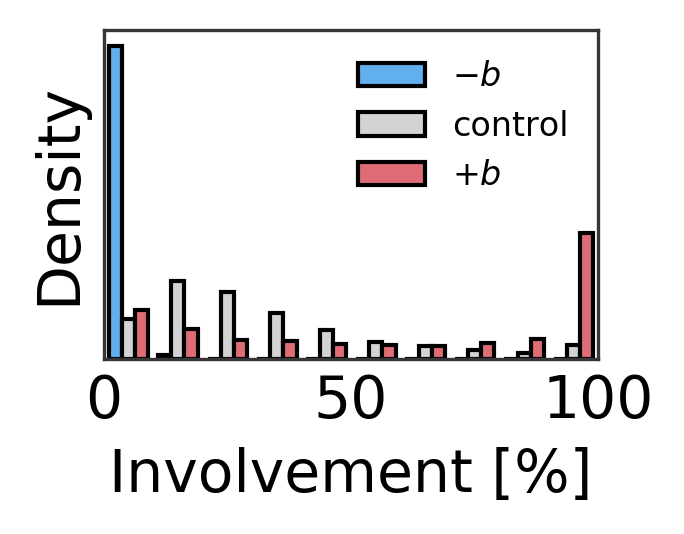

In [17]:
# Make a multiple-histogram of data-sets with different length.

#import matplotlib as mpl
#mpl.rc('text', usetex=False)
indices = [1, 0, 2]
colors = ['C1', 'lightgray', 'C0']
plt.figure(figsize=(2.5, 2))
plt.hist([involvements[n]*100 for n in indices], 10, histtype='bar', density=True, rwidth=0.8, edgecolor='k', color=colors, label=[labels[n] for n in indices])
#plt.title('Adaptation')
plt.legend(fontsize=8, loc=1, frameon=False)
plt.xticks([0, 50, 100])
plt.yticks([])
plt.ylabel("Density")
plt.xlabel("Involvement [%]")
plt.xlim([0, 100])
plt.tight_layout()
#plt.savefig("/Users/caglar/Documents/PhD/papers/2020-1-evolutionary-fitting/figures/assets/adaptation/assets/involvement-adaptation.pdf", transparent=True)
plt.show()    

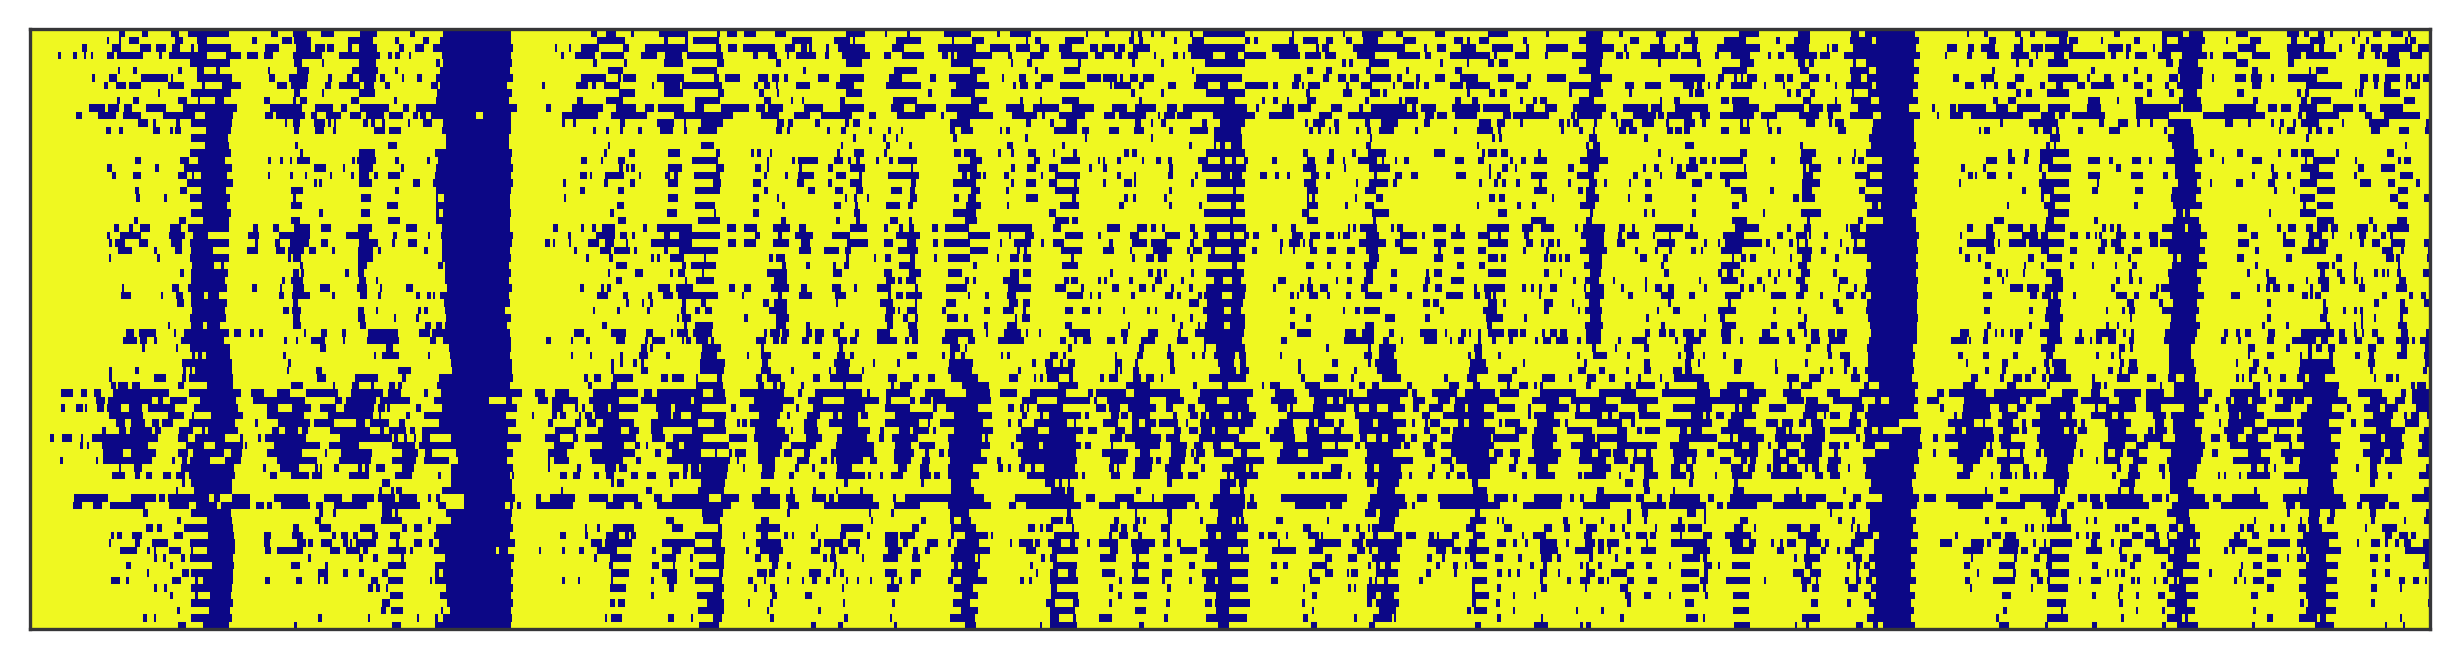

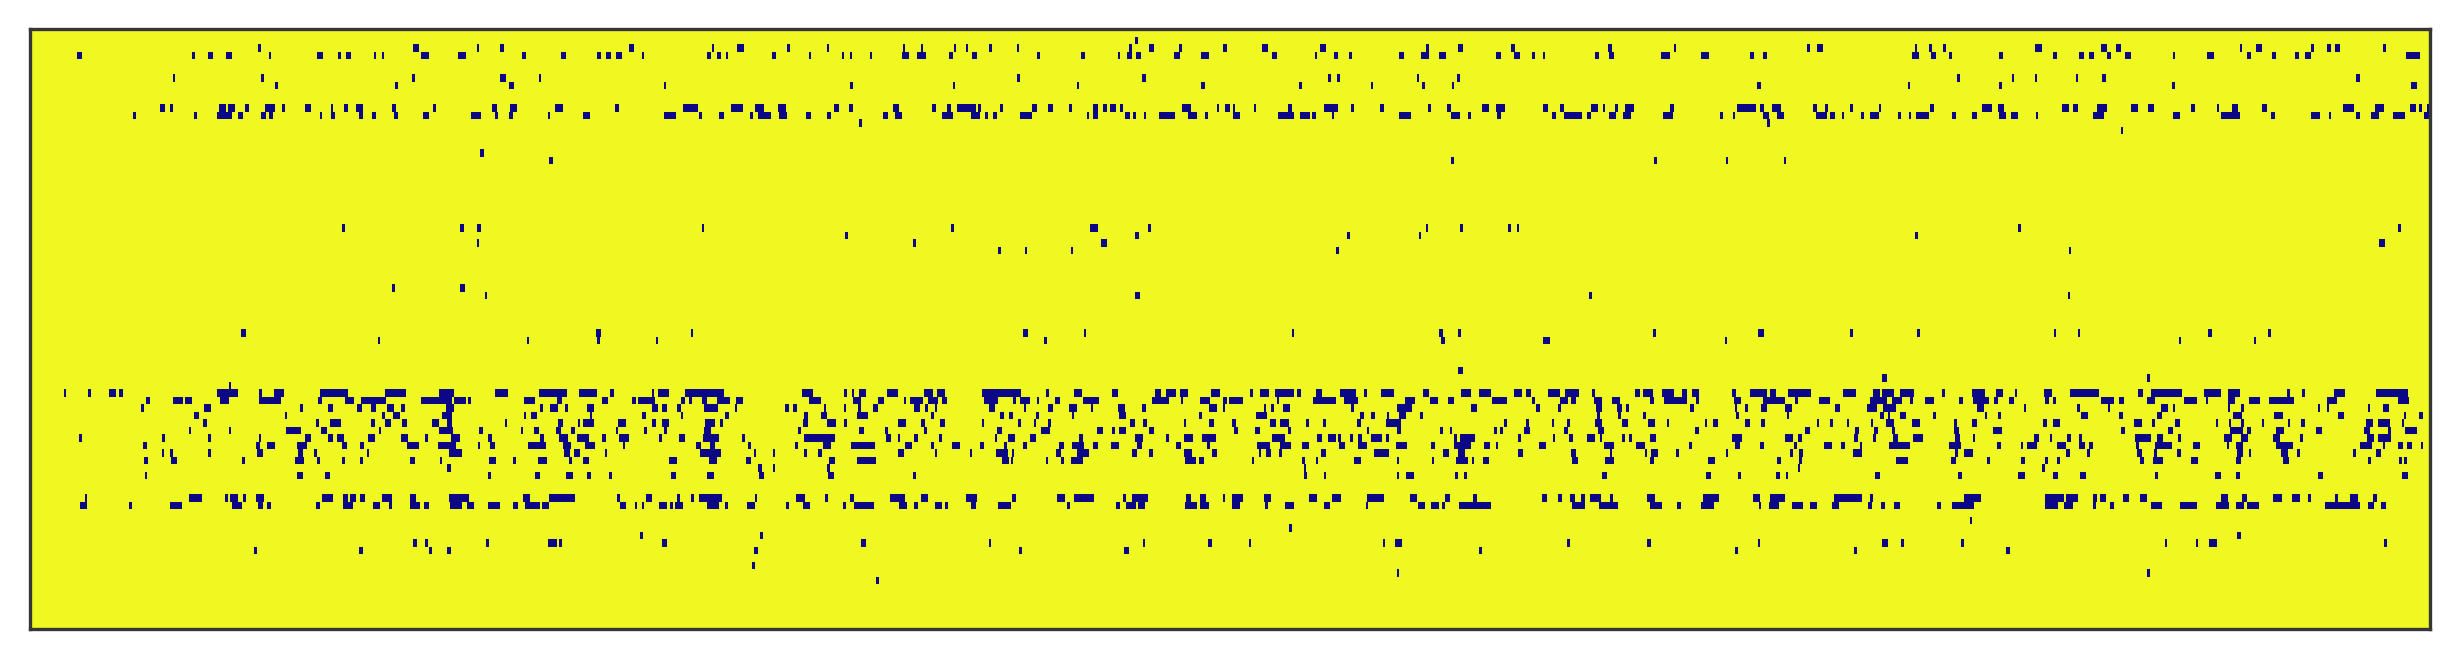

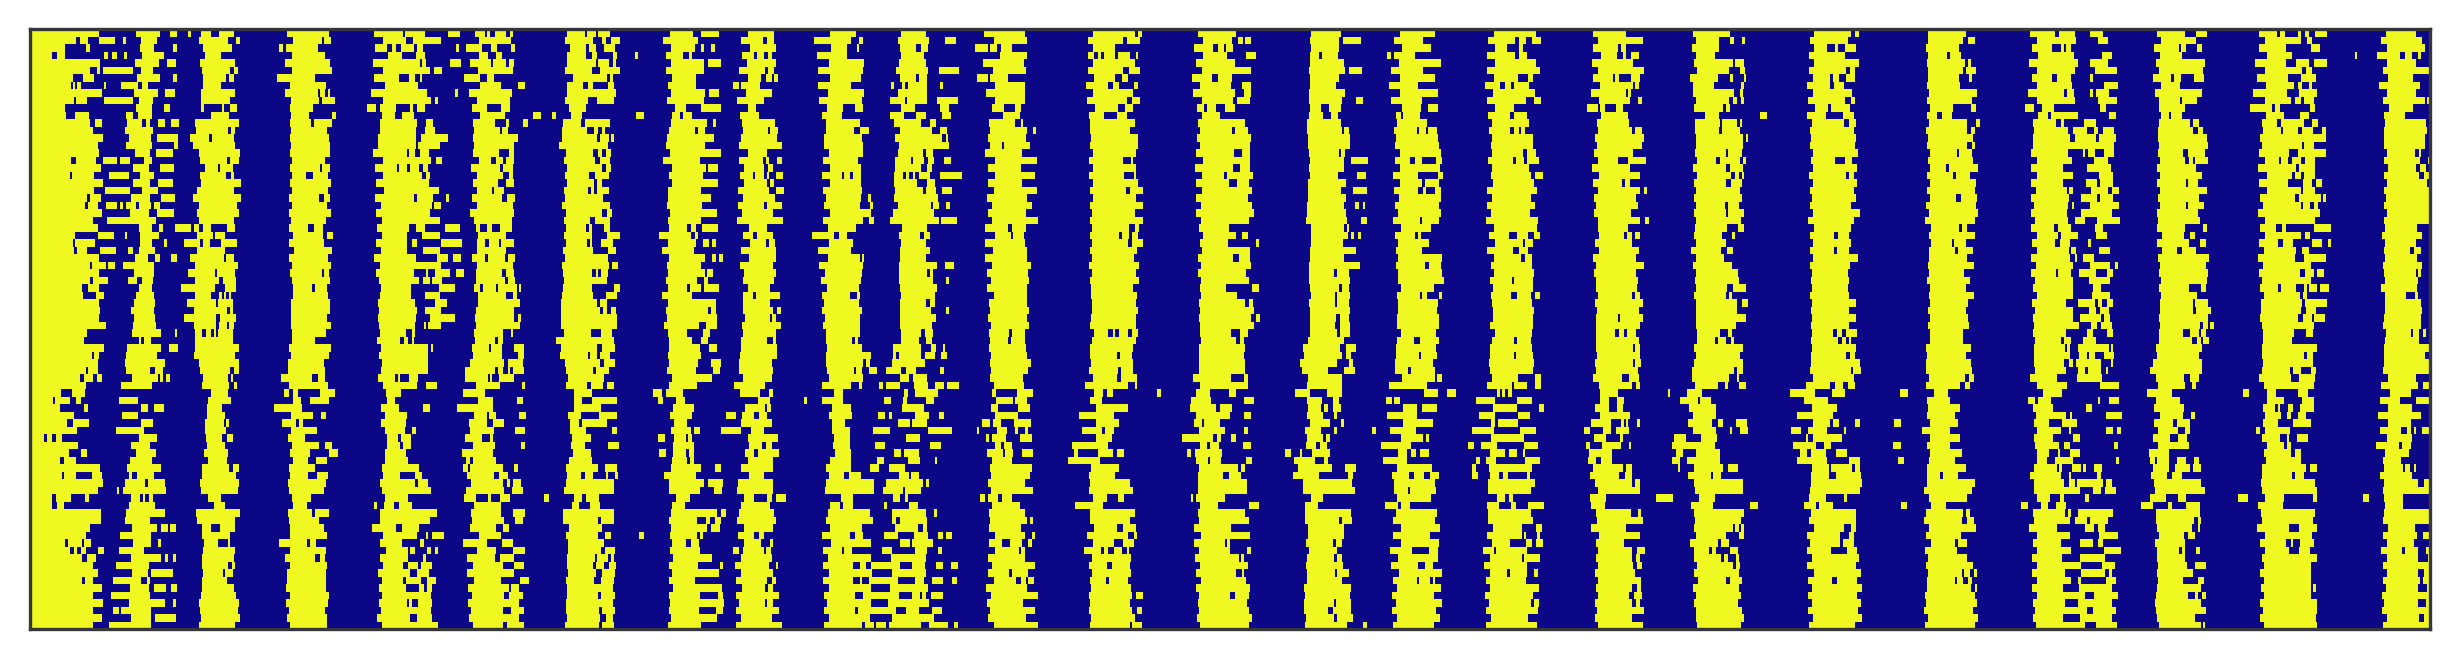

In [20]:
for i, model in enumerate(models):
    states = bp.detectSWs(model, filter_long=True)
    bp.plot_states_timeseries(model, states, title=None, labels=False)    
    #plt.savefig(f"/Users/caglar/Documents/PhD/papers/2020-1-evolutionary-fitting/figures/assets/adaptation/assets/states-{labels[i]}.pdf", transparent=True)
    plt.show()
    #bp.plot_state_durations(model, states)
    #plt.show()

In [23]:
import dill
for i, model in enumerate(models):
    fname = f"data/models/effect-of-adaptation-{labels[i]}.dill"
    print(fname)
    dill.dump(model, open(fname, "wb+"))

data/models/effect-of-adaptation-control.dill
data/models/effect-of-adaptation-$-b$.dill
data/models/effect-of-adaptation-$+b$.dill
